In [24]:
# @title
import numpy as np
import pandas as pd
from dataclasses import dataclass
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from tensorflow import keras
from tensorflow.keras import layers

In [25]:
data = pd.read_csv("data.csv", dtype={"date": "string"})
data.rename(columns={"y": "target"}, inplace=True)
data.rename(columns={"p_state0_h1": "p_state0"}, inplace=True)
data.rename(columns={"p_state1_h1": "p_state1"}, inplace=True)
data.rename(columns={"p_state2_h1": "p_state2"}, inplace=True)
print(data)

            date     spi_6  p_state0  p_state1  p_state2  Last Price  \
0     1992-01-12 -0.676211  0.188472  0.778493  0.033035        2.43   
1     1992-01-19 -0.408163  0.042357  0.918067  0.039576        2.48   
2     1992-01-26 -0.149762  0.031910  0.927547  0.040544        2.55   
3     1992-02-02 -0.012210  0.031731  0.926709  0.041559        2.57   
4     1992-02-09 -0.154111  0.031869  0.927580  0.040551        2.57   
...          ...       ...       ...       ...       ...         ...   
1744  2025-06-29 -0.317970  0.047144  0.919293  0.033563        4.00   
1745  2025-07-06 -0.346593  0.053727  0.912975  0.033298        4.10   
1746  2025-07-13 -0.113659  0.039652  0.926234  0.034114        3.87   
1747  2025-07-20  0.110532  0.035815  0.928811  0.035374        3.95   
1748  2025-07-27  0.294891  0.035153  0.926273  0.038575        3.87   

     price_date_used  fallback_days     ret_1  top_state  next_ret  target  
0         1992-01-10            2.0  0.016736          1  

#This notebook builds different modesl for predicting corn prices

The models are always a simple logistic regression and a LSTM, but the inputs change:
First we segment the training, val and test sets. Then we build different models:
1.   Only price data
2.   Price and prcp data
3.   Price and SPI data
4.   Price, SPI and HMM data


###1. Only price data

###1.1 Logistic regression

###1.2 LSTM

In [26]:
# @title
import numpy as np
import pandas as pd
from dataclasses import dataclass
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from tensorflow import keras
from tensorflow.keras import layers

#Current issues
LSTM with no CV folds because only predict one class that way - now predict all classes but model is random. Overfitting and also model
not learning from the data ( I tried doing a log reg and results similar - maybe issue in the data - but same if I run on just price -
could it be that notz enough data points - 1800?)

In [27]:
# @title
#Reproducibility of results
import os, random
os.environ["PYTHONHASHSEED"] = "0"
os.environ["TF_DETERMINISTIC_OPS"] = "1"  # TF >= 2.9

import numpy as np
random.seed(42)
np.random.seed(42)

import tensorflow as tf
tf.keras.utils.set_random_seed(42)
# If supported in your TF build and you want even stricter determinism on GPU:
# tf.config.experimental.enable_op_determinism()

#Standard imports
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, classification_report,
    confusion_matrix
)
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [28]:
# @title
###prepare functions and data
FEATURES = ["ret_1", "p_state0", "spi_6"]  # can be changed to other combinations

#helper functions
def make_static_splits(df: pd.DataFrame, test_start: str|pd.Timestamp):
    m = df.index >= pd.to_datetime(test_start)
    return df.loc[~m].copy(), df.loc[m].copy()

def rmse(y_true, y_pred): # this function to be removed because actually i dont do point forecasts currrnetly - but maybe i should as per literature??
    y_true = np.asarray(y_true, float); y_pred = np.asarray(y_pred, float)
    return float(np.sqrt(np.mean((y_pred - y_true) ** 2)))

def best_threshold(y_true, proba, metric="f1_macro"):
    grid = np.linspace(0.05, 0.95, 181)
    best_t, best = 0.5, -1.0
    for t in grid:
        pred = (proba >= t).astype(int)
        score = f1_score(y_true, pred, average="macro") if metric=="f1_macro" else f1_score(y_true, pred)
        if score > best:
            best, best_t = score, t
    return float(best_t)

def _class_weight_from_labels(y):
    # inverse-frequency weights normalized s.t. average weight ≈ 1
    y = np.asarray(y, int)
    classes, counts = np.unique(y, return_counts=True)
    K = len(classes); total = counts.sum()
    return {int(c): float(total/(K*cnt)) for c, cnt in zip(classes, counts)}

In [29]:
# @title
#prepare model
def make_sequences(df: pd.DataFrame, lookback: int, feature_cols, target_col="target"):
    """
    Build (X, y) where each X[i] is a window of length `lookback` ending at t-1,
    and y[i] is the target at time t (no look-ahead).
    """
    X, y = [], []
    V = df[feature_cols].values
    t = df[target_col].values
    for i in range(lookback, len(df)):
        X.append(V[i-lookback:i])
        y.append(t[i])
    return np.array(X), np.array(y)

def build_lstm(input_dim, lookback, units=64, dropout=0.2, lr=1e-3):
    m = keras.Sequential([
        layers.Input(shape=(lookback, input_dim)),
        layers.LSTM(units, return_sequences=False),
        layers.Dropout(dropout),
        layers.Dense(1, activation="sigmoid")
    ])
    m.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return m

# --------- Core training / evaluation blocks ---------
def fit_lstm_train_val(
    df_train: pd.DataFrame,
    df_val: pd.DataFrame,
    feature_cols=FEATURES,
    target_col="target",
    lookback=26,
    class_weight="balanced",  # "balanced" -> auto inverse-freq; dict {0:w0,1:w1}; or None
    epochs=150,
    batch_size=64,
    patience=20
):
    """
    Fit scaler on TRAIN, train LSTM on TRAIN with early-stopping on VAL.
    Returns: model, scaler, y_val_seq, proba_val, val_metrics_at_0p5, history_df
    """
    # Clean
    df_train = df_train.dropna(subset=feature_cols + [target_col]).copy()
    df_val   = df_val.dropna(subset=feature_cols + [target_col]).copy()

    # Scale on TRAIN only
    scaler = StandardScaler().fit(df_train[feature_cols])
    tr = df_train.copy(); va = df_val.copy()
    tr[feature_cols] = scaler.transform(tr[feature_cols])
    va[feature_cols] = scaler.transform(va[feature_cols])

    # Sequences
    X_tr, y_tr = make_sequences(tr, lookback, feature_cols, target_col)
    X_va, y_va = make_sequences(va, lookback, feature_cols, target_col)
    if len(X_tr) == 0 or len(X_va) == 0:
        raise ValueError("Not enough data to form sequences. Reduce lookback or provide more rows.")

    # Class weights
    cw = None
    if class_weight == "balanced":
        cw = _class_weight_from_labels(y_tr)
    elif isinstance(class_weight, dict):
        cw = class_weight

    # Build & train ONCE (deterministic settings)
    model = build_lstm(input_dim=X_tr.shape[2], lookback=lookback)
    cbs = [
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=patience, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=patience)
    ]
    history = model.fit(
        X_tr, y_tr,
        validation_data=(X_va, y_va),
        epochs=epochs,
        batch_size=batch_size,
        shuffle=False,  # time series
        callbacks=cbs,
        verbose=0,
        class_weight=cw
    )

    # Validation outputs & metrics at threshold 0.5
    proba_va = model.predict(X_va, verbose=0).ravel()
    pred_va  = (proba_va >= 0.5).astype(int)
    val_metrics_0p5 = {
        "acc": float(accuracy_score(y_va, pred_va)),
        "f1_macro": float(f1_score(y_va, pred_va, average="macro")),
        "roc_auc": float(roc_auc_score(y_va, proba_va)) if len(np.unique(y_va)) == 2 else np.nan,
        "rmse_prob": rmse(y_va, proba_va),
        "rmse_hard": rmse(y_va, pred_va.astype(float)),
        "classification_report": classification_report(y_va, pred_va, digits=3),
        "confusion_matrix": confusion_matrix(y_va, pred_va).tolist()
    }

    history_df = pd.DataFrame(history.history)
    return model, scaler, y_va, proba_va, val_metrics_0p5, history_df

def fit_lstm_final_on_trv(
    df_trv: pd.DataFrame,
    feature_cols=FEATURES,
    target_col="target",
    lookback=26,
    class_weight="balanced",
    epochs=150,
    batch_size=64,
    patience=20
):
    """
    Retrain LSTM on TRAIN+VAL with a tiny internal tail-holdout for ES (no Test peeking).
    """
    df_trv = df_trv.dropna(subset=feature_cols + [target_col]).copy()

    scaler = StandardScaler().fit(df_trv[feature_cols])
    trv = df_trv.copy()
    trv[feature_cols] = scaler.transform(trv[feature_cols])

    X_trv, y_trv = make_sequences(trv, lookback, feature_cols, target_col)
    if len(X_trv) == 0:
        raise ValueError("Not enough data in Train+Val to form sequences. Reduce lookback.")

    # small internal validation from tail of Train+Val (no Test peeking)
    monitor_k = max(min(max(len(X_trv)//10, 32), 256), 16)
    monitor_k = min(monitor_k, len(X_trv)//5) if len(X_trv) >= 5 else 0
    if monitor_k > 0:
        X_trv_train, y_trv_train = X_trv[:-monitor_k], y_trv[:-monitor_k]
        X_trv_valm,  y_trv_valm  = X_trv[-monitor_k:], y_trv[-monitor_k:]
        val_monitor = (X_trv_valm, y_trv_valm)
    else:
        X_trv_train, y_trv_train = X_trv, y_trv
        val_monitor = None

    cw = None
    if class_weight == "balanced":
        cw = _class_weight_from_labels(y_trv_train)
    elif isinstance(class_weight, dict):
        cw = class_weight

    model = build_lstm(input_dim=X_trv.shape[2], lookback=lookback)
    cbs = [
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=patience, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=patience)
    ]
    model.fit(
        X_trv_train, y_trv_train,
        epochs=epochs, batch_size=batch_size,
        validation_data=val_monitor,
        callbacks=cbs, verbose=0,
        class_weight=cw,
        shuffle=False
    )
    return model, scaler

def eval_lstm_on_split(model, scaler, df_split, feature_cols=FEATURES, target_col="target",
                       lookback=26, threshold=0.5):
    df_split = df_split.dropna(subset=feature_cols + [target_col]).copy()
    df_split[feature_cols] = scaler.transform(df_split[feature_cols])

    X, y = make_sequences(df_split, lookback, feature_cols, target_col)
    if len(X) == 0:
        raise ValueError("Not enough data in this split to form sequences at the chosen lookback.")
    proba = model.predict(X, verbose=0).ravel()
    pred  = (proba >= threshold).astype(int)

    metrics = {
        "acc": float(accuracy_score(y, pred)),
        "f1_macro": float(f1_score(y, pred, average="macro")),
        "roc_auc": float(roc_auc_score(y, proba)) if len(np.unique(y)) == 2 else np.nan,
        "rmse_prob": rmse(y, proba),
        "rmse_hard": rmse(y, pred.astype(float)),
        "classification_report": classification_report(y, pred, digits=3),
        "confusion_matrix": confusion_matrix(y, pred).tolist()
    }
    return metrics, y, proba, pred



In [30]:
#@title Hidden Code Example
# --------- End-to-end (no CV; Train -> Val -> retrain -> Test) ---------
def run_holdout_lstm_single(
    df: pd.DataFrame,
    test_start: str|pd.Timestamp,
    feature_cols=FEATURES,
    target_col="target",
    lookback=24,
    val_span: int|None = None,      # if None -> ~10% bounded in [26, 52]
    class_weight="balanced",        # "balanced", dict, or None
    epochs=150,
    batch_size=64,
    patience=20,
    tune_threshold: bool = True,
    tune_metric: str = "f1_macro"   # which metric to optimize when picking threshold
):
    # 0) Sort
    df = df.sort_index()

    # 1) Train/Val/Test split
    trainval, test = make_static_splits(df, test_start)
    if val_span is None:
        val_span = min(52, max(26, len(trainval)//10))
    val   = trainval.iloc[-val_span:].copy()
    train = trainval.iloc[:-val_span].copy()

    # 2) Train on Train, validate on Val
    model_tr, scaler_tr, y_va, proba_va, val_metrics_0p5, hist_df = fit_lstm_train_val(
        train, val,
        feature_cols=feature_cols, target_col=target_col,
        lookback=lookback,
        class_weight=class_weight,
        epochs=epochs, batch_size=batch_size, patience=patience
    )

    # 3) Threshold tuning on Val (optional)
    t_star = 0.5
    if tune_threshold:
        t_star = best_threshold(y_va, proba_va, metric=tune_metric)

    # Recompute Val metrics at tuned threshold for reporting
    df_val_scaled = val.dropna(subset=feature_cols + [target_col]).copy()
    df_val_scaled[feature_cols] = scaler_tr.transform(df_val_scaled[feature_cols])
    X_va2, y_va2 = make_sequences(df_val_scaled, lookback, feature_cols, target_col)
    proba_va2 = model_tr.predict(X_va2, verbose=0).ravel()
    pred_va2  = (proba_va2 >= t_star).astype(int)
    val_metrics_tuned = {
        "acc": float(accuracy_score(y_va2, pred_va2)),
        "f1_macro": float(f1_score(y_va2, pred_va2, average="macro")),
        "roc_auc": float(roc_auc_score(y_va2, proba_va2)) if len(np.unique(y_va2)) == 2 else np.nan,
        "rmse_prob": rmse(y_va2, proba_va2),
        "rmse_hard": rmse(y_va2, pred_va2.astype(float)),
        "classification_report": classification_report(y_va2, pred_va2, digits=3),
        "confusion_matrix": confusion_matrix(y_va2, pred_va2).tolist()
    }

    # 4) Retrain on Train+Val, evaluate once on Test (no peeking)
    trv = pd.concat([train, val]).copy()
    model_final, scaler_final = fit_lstm_final_on_trv(
        trv,
        feature_cols=feature_cols, target_col=target_col,
        lookback=lookback,
        class_weight=class_weight,
        epochs=epochs, batch_size=batch_size, patience=patience
    )
    test_metrics, y_test, proba_test, pred_test = eval_lstm_on_split(
        model_final, scaler_final, test,
        feature_cols=feature_cols, target_col=target_col,
        lookback=lookback, threshold=t_star
    )

    return {
        "val_metrics_tuned": val_metrics_tuned,
        "val_metrics_at_0p5": val_metrics_0p5,
        "test_metrics": test_metrics,
        "threshold_used": float(t_star),
        "splits": {
            "train": (train.index.min(), train.index.max()),
            "val":   (val.index.min(),   val.index.max()),
            "test":  (test.index.min(),  test.index.max())
        },
        "feature_cols": list(feature_cols),
        "lookback": lookback,
        "history_val": hist_df
    }



VAL (tuned): {'acc': 0.6785714285714286, 'f1_macro': 0.6571428571428571, 'roc_auc': 0.5833333333333334, 'rmse_prob': 0.4884652268962671, 'rmse_hard': 0.5669467095138409, 'classification_report': '              precision    recall  f1-score   support\n\n           0      0.667     0.500     0.571        12\n           1      0.684     0.812     0.743        16\n\n    accuracy                          0.679        28\n   macro avg      0.675     0.656     0.657        28\nweighted avg      0.677     0.679     0.669        28\n', 'confusion_matrix': [[6, 6], [3, 13]]}
VAL (0.5):   {'acc': 0.5714285714285714, 'f1_macro': 0.5087719298245614, 'roc_auc': 0.5833333333333334, 'rmse_prob': 0.4884652268962671, 'rmse_hard': 0.6546536707079771, 'classification_report': '              precision    recall  f1-score   support\n\n           0      0.500     0.250     0.333        12\n           1      0.591     0.812     0.684        16\n\n    accuracy                          0.571        28\n   macro

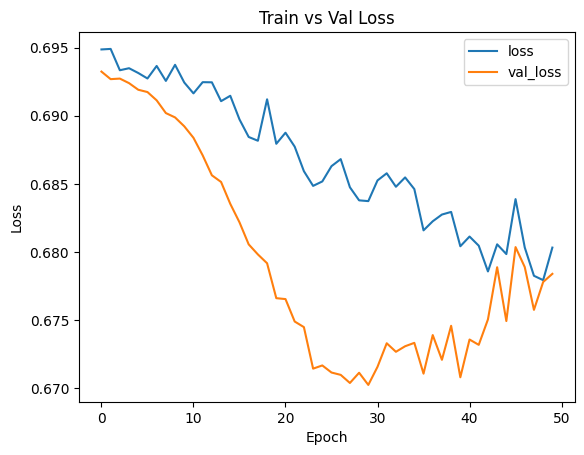

In [31]:
##finally run everything
data.index = pd.to_datetime(data["date"])
data = data.sort_index()

out = run_holdout_lstm_single(
    data,
    test_start="2018-01-01",
    feature_cols=["spi_6"],          # or use FEATURES
    target_col="target",
    lookback=24,
    val_span=None,                   # or set e.g., 52
    class_weight="balanced",         # or pass dict {0: w0, 1: w1} or None
    epochs=150, batch_size=64, patience=20,
    tune_threshold=True, tune_metric="f1_macro"
)

print("VAL (tuned):", out["val_metrics_tuned"])
print("VAL (0.5):  ", out["val_metrics_at_0p5"])
print("TEST:       ", out["test_metrics"])
print("Threshold:  ", out["threshold_used"])

# Plot the Train vs Val loss curve
out["history_val"][["loss","val_loss"]].plot()
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Train vs Val Loss")
plt.show()


In [32]:
data

,date,spi_6,p_state0,p_state1,p_state2,Last Price,price_date_used,fallback_days,ret_1,top_state,next_ret,target
date,,,,,,,,,,,,
1992-01-12,1992-01-12,-0.676211,0.188472,0.778493,0.033035,2.43,1992-01-10,2.0,0.016736,1,0.020576,1
1992-01-19,1992-01-19,-0.408163,0.042357,0.918067,0.039576,2.48,1992-01-17,2.0,0.020576,1,0.028226,1
1992-01-26,1992-01-26,-0.149762,0.031910,0.927547,0.040544,2.55,1992-01-24,2.0,0.028226,1,0.007843,1
1992-02-02,1992-02-02,-0.012210,0.031731,0.926709,0.041559,2.57,1992-01-31,2.0,0.007843,1,0.000000,0
1992-02-09,1992-02-09,-0.154111,0.031869,0.927580,0.040551,2.57,1992-02-07,2.0,0.000000,1,-0.007782,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-29,2025-06-29,-0.317970,0.047144,0.919293,0.033563,4.00,2025-06-27,2.0,-0.014778,1,0.025000,1
2025-07-06,2025-07-06,-0.346593,0.053727,0.912975,0.033298,4.10,2025-07-03,3.0,0.025000,1,-0.056098,0
2025-07-13,2025-07-13,-0.113659,0.039652,0.926234,0.034114,3.87,2025-07-11,2.0,-0.056098,1,0.020672,1
